In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [2]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DRF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRF.data', dtype='>f4')
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4')
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')

In [3]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt.zarr')

In [4]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
Density = Density.assign_coords(depth=('k', RC))
N2 = -9.81 *Density.mean('time').isel(i=slice(900,1100),j=slice(900,1100)).mean(['i','j']).diff('k')/Density.depth.diff('k')/1025
fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

In [5]:
zphi, RdS, vdS = baroclinic.neutral_modes_from_N2_profile(-RF[11:61], N2[10:60], fm,num_eigen=11,init_vector=None,num_Lanczos=None,iteration=None,tolerance=0)

In [6]:
# Load velocities
vels_filtered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/filtered_vels.zarr')
vels_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/unfiltered_vels.zarr')
eta_filtered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/filtered_eta_nom.zarr')
eta_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/unfiltered_eta_nom.zarr')

uvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr').sel(k=0)
vvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr').sel(k=0)
eta_eul = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/baro_nom.zarr')

uvel_filtered = vels_filtered.u.isel(time=slice(2,110))
vvel_filtered = vels_filtered.v.isel(time=slice(2,110))
ssh_filtered = eta_filtered.eta.isel(time=slice(2,110))

uvel_unfiltered = vels_unfiltered.u.isel(time=slice(2,110))
vvel_unfiltered = vels_unfiltered.v.isel(time=slice(2,110))
ssh_unfiltered = eta_unfiltered.eta.isel(time=slice(2,110))


#uvel_filtered = uvel_filtered.drop_vars('time')
#vvel_filtered = vvel_filtered.drop_vars('time')
#uvel_unfiltered = uvel_unfiltered.drop_vars('time')
#vvel_unfiltered = vvel_unfiltered.drop_vars('time')
grid = Grid(uvel_filtered, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [7]:

f = 2*2*np.pi/24/3600*np.sin(YC.reshape(2160,2160)[:,0]*np.pi/180)

In [8]:
def lanczos(x, a):
    return np.sinc(x/a)
def sinc2(x, a):
    return np.sinc(x/a)

window_width=72
weight = xr.DataArray(sinc2(np.expand_dims(np.arange(-window_width/2,window_width/2),1),np.expand_dims(np.pi/f/3600*1.1,0)), dims=['window','j'])
#weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
nofiles=uvel_unfiltered.time.shape[0]
u_eul_filtered = uvel_eul.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
v_eul_filtered = vvel_eul.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
eta_eul_filtered = eta_eul.eta.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
u_eul_filtered = u_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
eta_eul_filtered = eta_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

In [9]:
u_eul_filtered = u_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
u_eul_filtered = u_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
v_eul_filtered = v_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
v_eul_filtered = v_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
eta_eul_filtered = eta_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
eta_eul_filtered = eta_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
uvel_filtered = uvel_filtered.swap_dims({"i": "x0"})
uvel_filtered = uvel_filtered.swap_dims({"j": "y0"})
vvel_filtered = vvel_filtered.swap_dims({"i": "x0"})
vvel_filtered = vvel_filtered.swap_dims({"j": "y0"})
uvel_unfiltered = uvel_unfiltered.swap_dims({"i": "x0"})
uvel_unfiltered = uvel_unfiltered.swap_dims({"j": "y0"})
vvel_unfiltered = vvel_unfiltered.swap_dims({"i": "x0"})
vvel_unfiltered = vvel_unfiltered.swap_dims({"j": "y0"})

ssh_filtered = ssh_filtered.swap_dims({"i": "x0"})
ssh_filtered = ssh_filtered.swap_dims({"j": "y0"})
ssh_unfiltered = ssh_unfiltered.swap_dims({"i": "x0"})
ssh_unfiltered = ssh_unfiltered.swap_dims({"j": "y0"})

In [10]:
lons, lats = np.meshgrid(uvel_filtered.x0.values, uvel_filtered.y0.values)

In [11]:
def target_area_def(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat = center_point.x0.values.item(), -center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lat_0': center_lat, 'lon_0': center_lon, 'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def



def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 1, 0))

def ufunc_resample(data):
    target_def = target_area_def(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lons, lats=-lats)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['x0','y0'],['x0','y0']],output_core_dims=[['y1','x1']])
    return resampled

In [12]:
u_eul_resampled = ufunc_resample(u_eul_filtered.load())
v_eul_resampled = ufunc_resample(v_eul_filtered.load())
u_resampled = ufunc_resample(uvel_filtered.load())
v_resampled = ufunc_resample(vvel_filtered.load())
u_resampled_unfilt = ufunc_resample(uvel_unfiltered.load())
v_resampled_unfilt = ufunc_resample(vvel_unfiltered.load())

eta_resampled_unfilt = ufunc_resample(ssh_unfiltered.load())
eta_resampled = ufunc_resample(ssh_filtered.load())
eta_eul_resampled = ufunc_resample(eta_eul_filtered.load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [13]:
u_eul_resampled = u_eul_resampled.assign_coords(x1=("x1", u_eul_resampled.x1.values)).assign_coords(y1=("y1", u_eul_resampled.y1.values))
v_eul_resampled = v_eul_resampled.assign_coords(x1=("x1", v_eul_resampled.x1.values)).assign_coords(y1=("y1", v_eul_resampled.y1.values))
eta_eul_resampled = eta_eul_resampled.assign_coords(x1=("x1", v_eul_resampled.x1.values)).assign_coords(y1=("y1", v_eul_resampled.y1.values))
u_resampled = u_resampled.assign_coords(x1=("x1", u_resampled.x1.values)).assign_coords(y1=("y1", u_resampled.y1.values))
v_resampled = v_resampled.assign_coords(x1=("x1", v_resampled.x1.values)).assign_coords(y1=("y1", v_resampled.y1.values))
eta_resampled = eta_resampled.assign_coords(x1=("x1", v_resampled.x1.values)).assign_coords(y1=("y1", v_resampled.y1.values))
u_resampled_unfilt = u_resampled_unfilt.assign_coords(x1=("x1", u_resampled_unfilt.x1.values)).assign_coords(y1=("y1", u_resampled_unfilt.y1.values))
v_resampled_unfilt = v_resampled_unfilt.assign_coords(x1=("x1", v_resampled_unfilt.x1.values)).assign_coords(y1=("y1", v_resampled_unfilt.y1.values))
eta_resampled_unfilt = eta_resampled_unfilt.assign_coords(x1=("x1", v_resampled_unfilt.x1.values)).assign_coords(y1=("y1", v_resampled_unfilt.y1.values))

In [14]:
with ProgressBar():
    u2_ps = xrft.power_spectrum(u_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps = xrft.power_spectrum(v_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta_ps = xrft.power_spectrum(eta_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
vel_ps = (u2_ps + v2_ps)*0.5

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [15]:
with ProgressBar():
    u2_ps_unfilt = xrft.power_spectrum(u_resampled_unfilt, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps_unfilt = xrft.power_spectrum(v_resampled_unfilt, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta_ps_unfilt = xrft.power_spectrum(eta_resampled_unfilt, dim=['x1','y1','time'],window=True,window_correction=True).compute()
vel_ps_unfilt = (u2_ps_unfilt + v2_ps_unfilt)*0.5

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [16]:
with ProgressBar():
    u2_ps_eul = xrft.power_spectrum(u_eul_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps_eul = xrft.power_spectrum(v_eul_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta_ps_eul = xrft.power_spectrum(eta_eul_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
vel_ps_eul = (u2_ps_eul + v2_ps_eul)*0.5

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [17]:
# Add the isotropic calculation (k,l) -> (k_r) (azimuthally average)
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')

    return kr, iso_f

def iso_spec_over_depth(ds):
    
    Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen , Zlen, int(klen/nfactor+1)])

    for j in range(0,omegalen):
        for i in range(0,Zlen):
            kr, ds_iso[j,i,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(Z=i, freq_time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'Z': ds.Z.values, 'kr':kr }, 
                             dims=['freq_time','Z', 'kr'])
    
    return ds_iso_xr

def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_x1)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_x1, ds.freq_y1, ds.isel(freq_time=j), 
                            len(ds.freq_x1), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'kr':kr }, 
                             dims=['freq_time','kr'])
    
    return ds_iso_xr

In [18]:
ps_iso = iso_spec(vel_ps)
ps_iso_unfilt = iso_spec(vel_ps_unfilt)
ps_iso_eul = iso_spec(vel_ps_eul)
eta_iso = iso_spec(eta_ps)
eta_iso_unfilt = iso_spec(eta_ps_unfilt)
eta_iso_eul = iso_spec(eta_ps_eul)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


In [175]:
kr    = ps_iso.kr
omegaM = np.nan*np.ones([kr.shape[0], 11])
for i in range(1,11):
    
    Kdi = 1/RdS[i]
    omegaM[:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600

In [176]:
omegaM[:,10]

array([0.35709351, 0.35732418, 0.35828804, 0.36026302, 0.36317772,
       0.36714636, 0.37215034, 0.3778929 , 0.38439398, 0.39193709,
       0.40020629, 0.40898759, 0.41867467, 0.4289277 , 0.4395388 ,
       0.45096994, 0.46286754, 0.47517462, 0.48809984, 0.50109009,
       0.51424539, 0.52806264, 0.54234512, 0.55698933, 0.5717566 ,
       0.58634618, 0.6015465 , 0.61718908, 0.63252603, 0.6482172 ,
       0.66443518, 0.68057436, 0.69644565, 0.7127641 , 0.72950971,
       0.74629118, 0.76297197, 0.77955012, 0.79626068, 0.81340722,
       0.83059446, 0.84779221, 0.86501034, 0.88231242, 0.89960953,
       0.91690624, 0.93450248, 0.9523309 , 0.96986134, 0.98734084,
       1.00484774, 1.02261229, 1.04076009, 1.05874178, 1.0764493 ,
       1.09429761, 1.11219284, 1.1300996 , 1.14815071, 1.16635954,
       1.18448118, 1.20252113, 1.22070185, 1.23885279, 1.25698389,
       1.27524845, 1.29351901, 1.31174613, 1.32997969, 1.34823207,
       1.36647809, 1.38473337, 1.40316367, 1.42165418, 1.43996

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:9: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:28: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:47: UserWarning: Log scale: values of z <= 0 have been masked


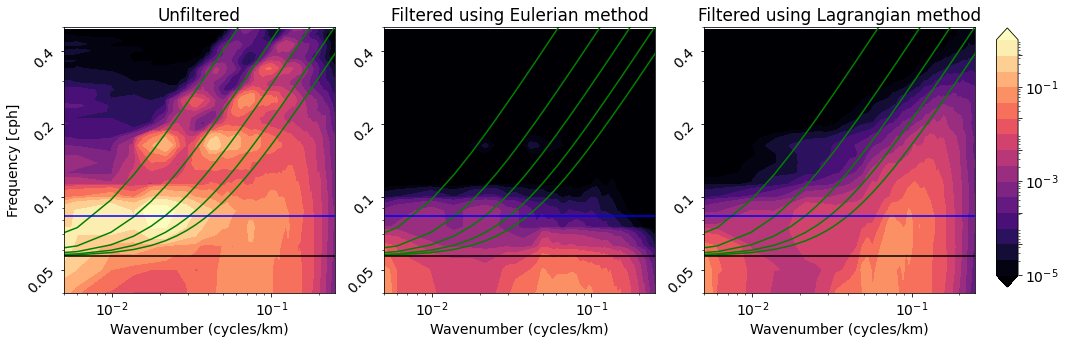

In [20]:
yticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-5,0,16)
lev = np.power(10, lev_exp)
plt.subplot(131)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(132)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_eul,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Filtered using Eulerian method')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(133)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Filtered using Lagrangian method')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)



fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)


fig.savefig('wavenumber_freq.png')

In [21]:

ps_iso_tofilt = ps_iso_unfilt
ps_iso_tofilt = ps_iso_tofilt.where(ps_iso_tofilt.freq_time*xr.ones_like(ps_iso_tofilt)*3600<omegaM[:,10]/np.pi/2)


eta_iso_tofilt = eta_iso_unfilt
eta_iso_tofilt = eta_iso_tofilt.where(eta_iso_tofilt.freq_time*xr.ones_like(eta_iso_tofilt)*3600<omegaM[:,10]/np.pi/2)


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:3: UserWarning: Log scale: values of z <= 0 have been masked
  app.launch_new_instance()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:23: UserWarning: Log scale: values of z <= 0 have been masked


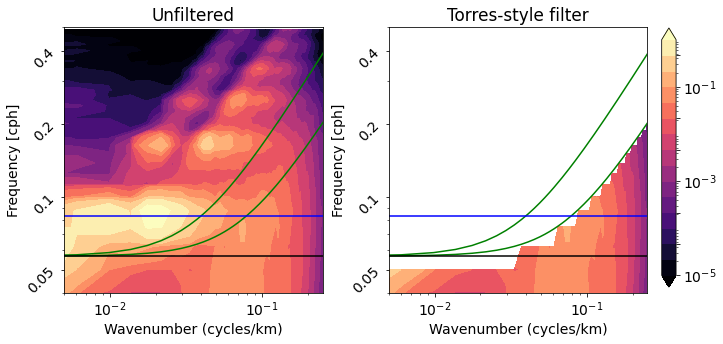

In [22]:
plt.figure(figsize=(10,5))
plt.subplot(121)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(122)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_tofilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Torres-style filter')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('torres-style-filter.png')

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:3: UserWarning: Log scale: values of z <= 0 have been masked
  app.launch_new_instance()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:23: UserWarning: Log scale: values of z <= 0 have been masked


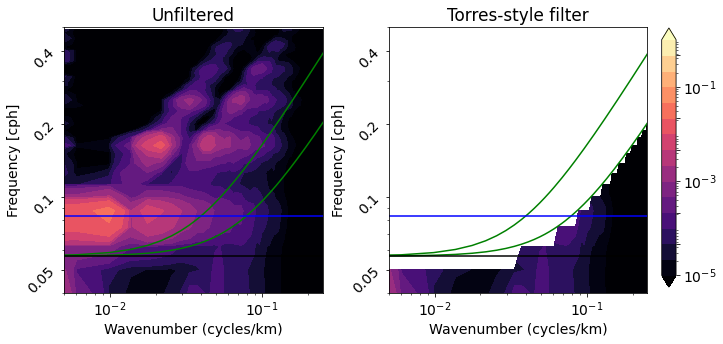

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(121)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*eta_iso_unfilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(122)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*eta_iso_tofilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Torres-style filter')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('torres-style-filter.png')

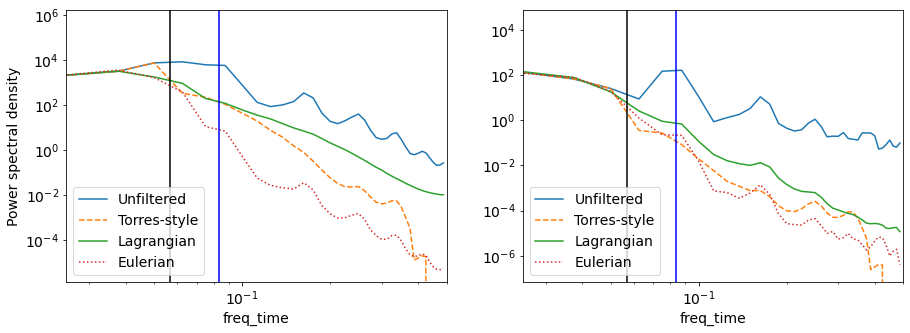

In [24]:
plt.figure(figsize=(15,5))

plt.subplot(121)

ps_iso_unfilt.sum('kr').assign_coords(freq_time=ps_iso_unfilt.freq_time*3600).plot()
plt.xscale('log')
plt.yscale('log')

ps_iso_tofilt.sum('kr').assign_coords(freq_time=ps_iso_tofilt.freq_time*3600).plot(linestyle ='--')
plt.xscale('log')
plt.yscale('log')

ps_iso.sum('kr').assign_coords(freq_time=ps_iso.freq_time*3600).plot()
plt.xscale('log')
plt.yscale('log')

ps_iso_eul.sum('kr').assign_coords(freq_time=ps_iso_eul.freq_time*3600).plot(linestyle =':')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.025,0.5)
plt.ylabel('Power spectral density')

plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')

plt.legend(['Unfiltered','Torres-style','Lagrangian','Eulerian'])

plt.subplot(122)

eta_iso_unfilt.sum('kr').assign_coords(freq_time=ps_iso_unfilt.freq_time*3600).plot()
plt.xscale('log')
plt.yscale('log')

eta_iso_tofilt.sum('kr').assign_coords(freq_time=ps_iso_tofilt.freq_time*3600).plot(linestyle ='--')
plt.xscale('log')
plt.yscale('log')

eta_iso.sum('kr').assign_coords(freq_time=ps_iso.freq_time*3600).plot()
plt.xscale('log')
plt.yscale('log')

eta_iso_eul.sum('kr').assign_coords(freq_time=ps_iso_eul.freq_time*3600).plot(linestyle =':')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.025,0.5)

plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')

plt.legend(['Unfiltered','Torres-style','Lagrangian','Eulerian'])

fig.savefig('torres-style-spectrum.png')

In [261]:
with ProgressBar():
    u2_xs_unfilt = xrft.dft(u_resampled_unfilt, dim=['x1','y1','time'],window=True).compute()
    v2_xs_unfilt = xrft.dft(v_resampled_unfilt, dim=['x1','y1','time'],window=True).compute()
    v2_xs_unfilt_nowindow = xrft.dft(v_resampled_unfilt, dim=['x1','y1','time']).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [262]:
Kdi

0.0009273009584484243

In [263]:
kx = v2_xs_unfilt.freq_x1
ky = v2_xs_unfilt.freq_y1
kr = np.sqrt(kx**2+ky**2)
omegaM = np.nan*np.ones([kr.shape[0], kr.shape[1], 11])
for i in range(1,11):
    Kdi = 1/RdS[i]
    omegaM[:,:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600

u2_xs_tofilt = u2_xs_unfilt
u2_xs_tofilt = u2_xs_tofilt.where(np.abs(v2_xs_tofilt.freq_time)*xr.ones_like(v2_xs_tofilt)*3600<omegaM[:,:,10]/np.pi/2)
    
v2_xs_tofilt = v2_xs_unfilt
v2_xs_tofilt = v2_xs_tofilt.where(np.abs(v2_xs_tofilt.freq_time)*xr.ones_like(v2_xs_tofilt)*3600<omegaM[:,:,10]/np.pi/2)

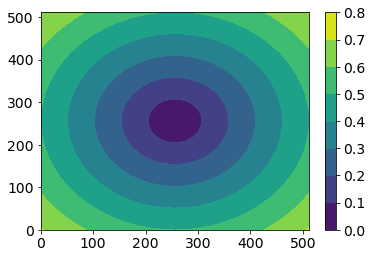

In [169]:
cs = plt.contourf(kr)
plt.colorbar(cs)

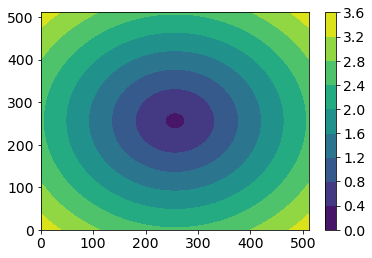

In [166]:
cs = plt.contourf(omegaM[:,:,10])
plt.colorbar(cs)

In [265]:
inversed_untouched = xrft.idft(v2_xs_unfilt_nowindow, dim=['freq_x1','freq_y1','freq_time']).compute()
inversed_windowed = xrft.idft(v2_xs_unfilt, dim=['freq_x1','freq_y1','freq_time'],window='hanning').compute()
u_inversed_torres_filt = xrft.idft(u2_xs_tofilt.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
v_inversed_torres_filt = xrft.idft(v2_xs_tofilt.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()

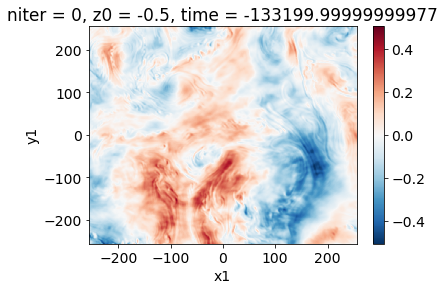

In [267]:
(inversed_untouched.isel(time=3).real).plot()

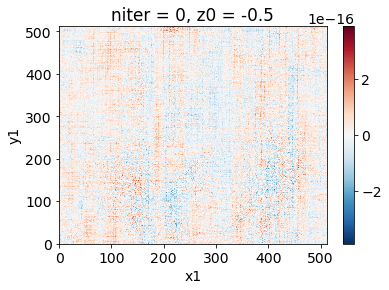

In [142]:
(v_resampled_unfilt.isel(time=3).real.drop_vars(['x1','y1'])-inversed_untouched.isel(time=3).real.drop_vars(['x1','y1'])).plot()#

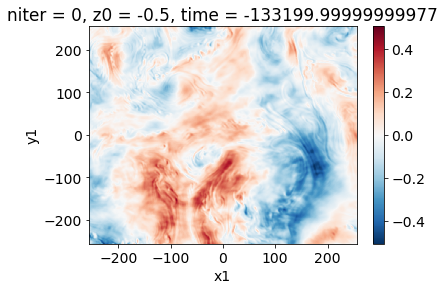

In [141]:
inversed_untouched.isel(time=3).real.plot()
#Note - need to define kr in wn space the filter along both axes at the same time. 

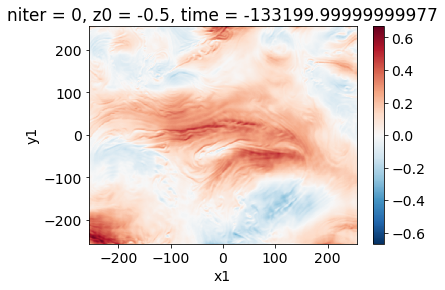

In [192]:
u_inversed_torres_filt.isel(time=3).real.plot()

In [273]:
grid1 = Grid(u_inversed_torres_filt, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})

In [274]:
u_torres = grid1.interp(u_inversed_torres_filt,'X')
v_torres = grid1.interp(v_inversed_torres_filt,'Y')
u_lag = grid1.interp(u_resampled,'X')
v_lag = grid1.interp(v_resampled,'Y')
u_orig = grid1.interp(u_resampled_unfilt,'X')
v_orig = grid1.interp(v_resampled_unfilt,'Y')

In [275]:
div_orig = ((grid1.diff(u_orig.drop_vars('y1'), 'X') + grid1.diff(v_orig.drop_vars('x1'), 'Y')) / (270000*2/512))
div_torres = ((grid1.diff(u_torres, 'X') + grid1.diff(v_torres, 'Y')) / (270000*2/512))
div_lag = ((grid1.diff(u_lag.drop_vars('y1'), 'X') + grid1.diff(v_lag.drop_vars('x1'), 'Y')) / (270000*2/512))

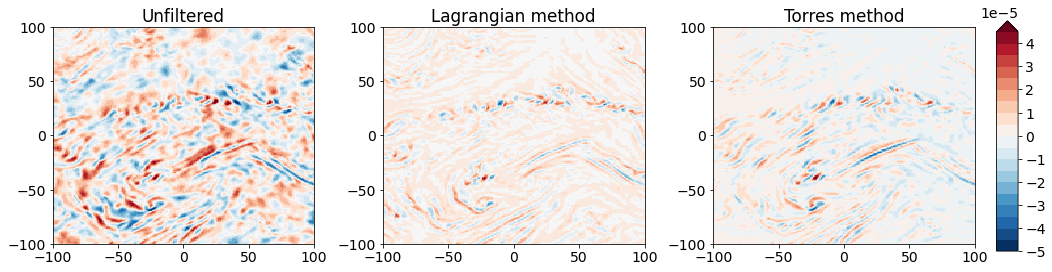

In [284]:
plt.figure(figsize=(15,4))
plt.subplot(131)
div_orig.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*5*10**-5, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Unfiltered')

plt.subplot(132)
div_lag.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*5*10**-5, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Lagrangian method')

plt.subplot(133)
cs=div_torres.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*5*10**-5, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Torres method')

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('divergence.png')

In [305]:
zeta_orig = ((-grid.diff(u_orig * 270000*2/512, 'Y') + grid.diff(v_orig * 270000*2/512, 'X'))/1054.6**2
            ).assign_coords({"x1_g": (["x1_g"], np.arange(-256,256))}).assign_coords({"y1_g": (["y1_g"], np.arange(-256,256))})
zeta_torres = ((-grid.diff(u_torres * 270000*2/512, 'Y') + grid.diff(v_torres * 270000*2/512, 'X'))/1054.6**2
               ).assign_coords({"x1_g": (["x1_g"], np.arange(-256,256))}).assign_coords({"y1_g": (["y1_g"], np.arange(-256,256))})
zeta_lag = ((-grid.diff(u_lag * 270000*2/512, 'Y') + grid.diff(v_lag * 270000*2/512, 'X'))/1054.6**2
            ).assign_coords({"x1_g": (["x1_g"], np.arange(-256,256))}).assign_coords({"y1_g": (["y1_g"], np.arange(-256,256))})

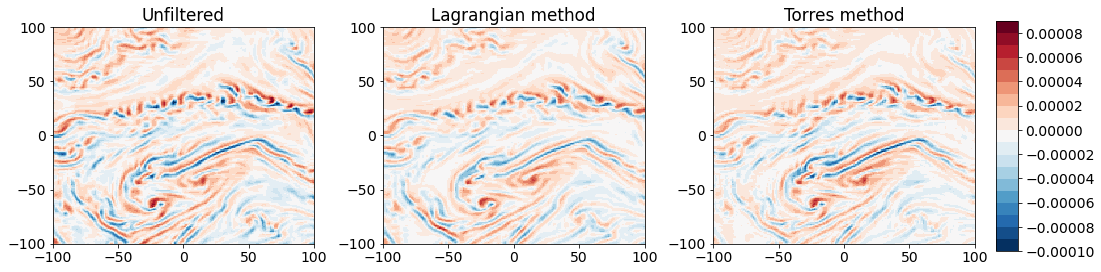

In [307]:
plt.figure(figsize=(15,4))
plt.subplot(131)
zeta_orig.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*10**-4, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Unfiltered')

plt.subplot(132)
zeta_lag.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*10**-4, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Lagrangian method')

plt.subplot(133)
cs=zeta_torres.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*10**-4, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Torres method')

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('zeta.png')

In [298]:
zeta_orig


<xarray.DataArray (time: 80, y1_g: 512, x1_g: 512)>
array([[[-2.32667899e-04, -1.53794356e-04, -1.59750528e-04, ...,
         -1.38103874e-04, -1.31588801e-04, -1.36236875e-04],
        [-1.98851826e-04, -1.74579086e-05, -1.96453633e-05, ...,
          3.11749174e-06,  2.89245567e-06,  7.73563814e-06],
        [-2.17022890e-04, -1.75603032e-05, -2.06130729e-05, ...,
          4.21709310e-06,  5.42208085e-06,  9.22934508e-06],
        ...,
        [ 1.18631120e-05, -1.67755647e-05, -3.24031999e-05, ...,
         -2.39155687e-05, -3.15699415e-05, -8.51353527e-06],
        [ 1.97146926e-05, -7.29496920e-06, -2.25589221e-05, ...,
         -9.34427377e-06, -2.78671160e-05, -2.23165935e-05],
        [ 1.40324765e-05, -9.37767711e-07, -1.77018869e-05, ...,
          8.51578601e-06, -1.47433111e-05, -3.26052843e-05]],

       [[-2.02721139e-04, -1.62995490e-04, -1.51148167e-04, ...,
         -1.32857768e-04, -1.25328945e-04, -1.26214946e-04],
        [-1.64906426e-04, -1.93683036e-05, -2.08516549e-05, ...,
          3.55174247e-06,  2.70622075e-06,  6.59475292e-06],
        [-1.79242283e-04, -1.86307485e-05, -2.01961036e-05, ...,
          4.04481526e-06,  4.40153566e-06,  8.37905576e-06],
...
        [ 1.79033784e-04, -2.99581806e-05, -2.94672555e-05, ...,
          3.27580509e-05,  2.87099464e-05,  2.01478573e-05],
        [ 1.75246002e-04, -2.88579222e-05, -2.71404543e-05, ...,
          3.02333555e-05,  2.70045694e-05,  1.25219162e-05],
        [ 1.74950961e-04, -2.00094395e-05, -2.27222406e-05, ...,
          2.77019475e-05,  2.93894348e-05,  6.03787243e-06]],

       [[-1.56509836e-04, -3.31946099e-04, -3.46589583e-04, ...,
         -2.70153348e-04, -2.73632395e-04, -2.80292973e-04],
        [ 8.54207813e-05, -2.53678594e-05, -1.74002651e-05, ...,
          3.11804761e-06, -4.96644319e-07,  8.33550575e-06],
        [ 7.15162739e-05, -2.65935484e-05, -2.34090968e-05, ...,
          2.26815688e-06,  9.34374747e-07,  6.82097773e-06],
        ...,
        [ 1.85303768e-04, -3.09477679e-05, -2.92102931e-05, ...,
          3.46805792e-05,  2.93721113e-05,  1.84689097e-05],
        [ 1.86066909e-04, -3.01310665e-05, -2.84315403e-05, ...,
          3.08176279e-05,  2.72183636e-05,  1.23093727e-05],
        [ 1.90989969e-04, -2.23548546e-05, -2.60747802e-05, ...,
          2.76902427e-05,  2.89278039e-05,  5.67215549e-06]]])
Coordinates:
  * time     (time) int64 3600 7200 10800 14400 ... 277200 280800 284400 288000
Dimensions without coordinates: y1_g, x1_g